## Chapter 3 – Classification
this is the revision for chapter 3

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# MINIST
*   **MNIST** dataset -- 70000 small images of digits handwritten by people
*  Each image is labeled with the digit it represents

#### 1.  **Fetch the MNIST dataset using Scikit-learn function** 

In [2]:
#----- this is deprecated
# from sklearn.datasets import fetch_mldata
# mnist = fetch_mldata('MNIST original')
# mnist

**Warning**: fetch_mldata() is deprecated since Scikit-Learn 0.20. 
*  You should use **fetch_openml()** instead. However, it returns the **unsorted** MNIST dataset, whereas fetch_mldata() returned the dataset sorted by target (the training set and the test test were sorted separately).
*  In general, this is fine, but if you want to get the **exact same results as before**, you need to sort the dataset using the following function:

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

#### Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including the following:
- A DESCR key describing the dataset
- A data key containing an array with __one row per instance__ and __one column per feature__
- A target key containing an array with the __labels__

In [4]:
X,y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

- 70000 images, 784 features
- each image is 28x28=784 pixels. each feature represents pixel intensity (0-255)

In [5]:
y.shape

(70000,)

Take a peak at one digit from the dataset:

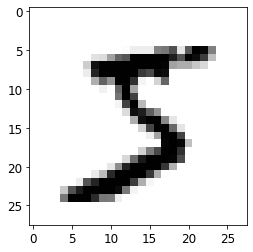

In [6]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("on")

plt.show()

In [7]:
y[0] # to see it's label (looks like zero)

'5'

In [8]:
y = y.astype(np.uint8) # make the lables are all integer values

In [9]:
# This function helps plot the digit as a 28x28 array
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [10]:
# EXTRA: plot a few instance in a picture (default 10 digit per row)
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    
    #Join a sequence of arrays along an existing axis
    image = np.concatenate(row_images, axis=0) 
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

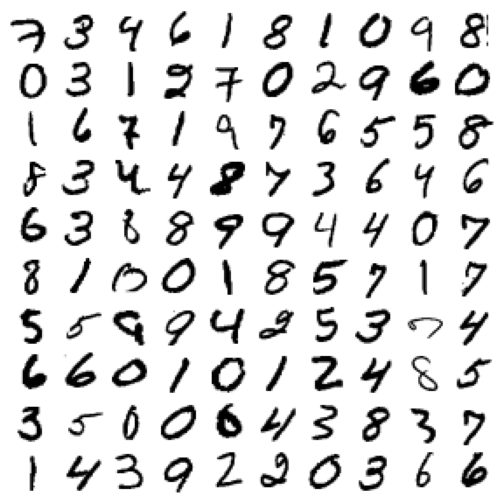

In [11]:
plt.figure(figsize=(9,9))
example_images = X[5000:5100]
plot_digits(example_images, images_per_row=10)
plt.show()

In [12]:
y[0]

5

The training set is already shuffled for us
- guarantees that all cross-validation folds will be similar 

In [13]:
# split traning and testing set. 
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training A Binary Classifier

- simplify the problem for now and only try to identify one digit—number 5
- his “5-detector” will be an example of a __binary classifier__
- distinguishing between just two classes, 5 and not-5

In [14]:
#create the target vectors for this classification task:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

#### Test: Stochastic Gradient Descent (SGD) classifier
- Scikit-Learn’s SGDClassifier class
- advantage: capable of handling very large datasets efficiently
- SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning)

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
sgd_clf.predict([some_digit]) # detect the image for number 5

array([ True])

# Evaluate Model's Performance

## Measuring Accuracy Using Cross-Validation

* Option 1: Customized Cross Validation funciton

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    #counts the number of correct predictions and outputs the ratio of correct predictions
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

/home/chenlequn/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [18]:
from sklearn.model_selection import cross_val_score
# cv=3, three fold stratified sampling 
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [19]:
# ust classifies every single image in the “not-5” class
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Why the accuracy is so High (All higher than 90%) ???
- This is because only 10% of the images are number 5.
- So This kind of performance measures is not correct.

--> accuracy is generally not the preferred performance measure for classifiers
specially when you are dealing with skewed datasets
(i.e., when some classes are much more frequent than others)

## Confusion Matrix
-- better way to evaluate the performance of a classifier 
* count the number of times instances of class A are classified as class B (number of wrong predictions)
* we need a set of predictions to compared with the actual label values

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# cross_val_predict() performs Kfold cross-validation, it returns the
# predictions made on each test fold. 

In [22]:
# Compute the confusion matrix
# by comparing the predictino value and target actaul value
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- Each row in a confusion matrix represents an actual class
- Each column represents a predicted class
- first row of this matrix considers non-5 images (__the negative class__): <br/>
  53892 of them were correctly classified as non-5s (they are called __true negatives__), <br/>
  while the remaining 687 were wrongly classified as 5s (__false positives__)
- Second Row considers the images of 5s (__the positive class__):<br/>
  1891 were wrongly classified as non-5s (__false negatives__), <br/>
  while the remaining 3530 were correctly classified as 5s (__true positives__). 
  <br/>
  <br/>
- A perfect classifier would have only true positives and true negatives, nonzero values only on its main diagonal

In [23]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision of the classifier
the accuracy of the __positive predictions__<br/>
* TP/(TP+FP) <br/>
TP is the number of true positives, and FP is the number of false positives. 
* Another matrix: __recall, also called sensitivity or the true positive rate (TPR)__:<br/>
  the ratio of positive instances
  that are correctly detected by the classifier : TP/(TP+FN) <br/>
  FN : the number of false negatives

### Precision and Recall
In Scikit learn:

In [24]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred) # == 3530 / (3530 + 687)

0.8370879772350012

When it claims an image represents a 5, it is correct only 83.7% of the
time

In [25]:
recall_score(y_train_5, y_train_pred) # == 3530 / (3530 + 1891)

0.6511713705958311

it only detects 65.1% of the 5s

### __*F1 score*__
combine precision and recall into a single metric called
the __*F1 score*__
- The F score is the harmonic mean of precision and recall 
- F1 = 2/ (1/precision + 1/recall) = 2 * (precision x recall)/(precesion + recall) = TP/(TP+ (FN+FP)/2)

- The harmonic mean gives much more weight to __low values__
- The F1 score is high only if both precision and recall are high

In [26]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

## __precision/recall trade-off__
- increasing precision reduces recall, and vice versa
- F1 score favors classifiers that have similar precision and recall

### look at how the **SGDClassifier** makes its classification decisions.
- it computes a __score__ based on a ***decision function*** 
- If that score is greater than a __decision threshold__, it assigns the instance to the positive class; 
  otherwise it assigns it to the negative class

Scikit-Learn does not let you set the threshold directly
- but it does give you access to the decision scores that it uses to make predictions
- decision_function() method, which returns a score for each instance

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [28]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [29]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

__How do you decide which threshold to use?__ <br/>
use the __cross_val_predict()__ function to get the scores of all instances in the training set, <br/>
return the decision scores for instance

In [30]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [31]:
from sklearn.metrics import precision_recall_curve

# to compute the precision and recall for all possible thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

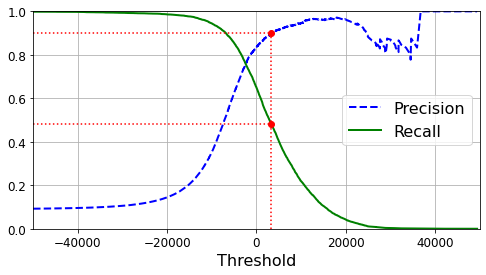

In [32]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown


# np.argmax() will give you the first index of the maximum value
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# Highlight the threshold, add ledgend axis label and grid
plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown                                       # Not shown
plt.show()

plot precision directly against recall

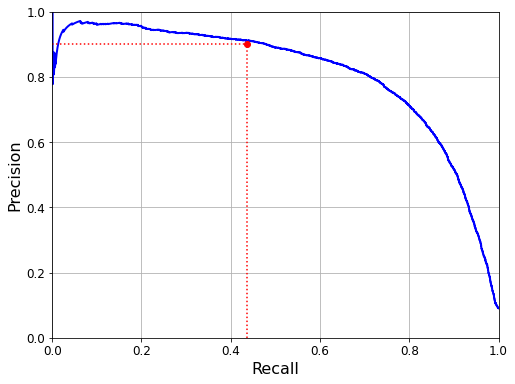

In [33]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
# Highlight 
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

precision really starts to fall sharply around 80% recall
- select a precision/recall trade-off just before that drop
- Suppose you decide to aim for 90% precision

In [34]:
# search for the lowest threshold that gives you at least 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [35]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [36]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [37]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

__As we can see, the precision reaches 90%, but recall is too low. not good__

## The ROC Curve

- The __receiver operating characteristic (ROC)__ curve is another common tool used with binary classifiers
- ROC curve plots the __true positive rate (another name for recall)__ against the __false positive rate (FPR)__
- __FPR__ is the ratio of negative instances that are incorrectly classified as positive
- the __true negative rate (TNR)__, which is the ratio of negative instances that are correctly classified as negative
- __FPR__  equals to __1-TNR__
- The TNR is also called __specificity__
- ROC curve plots __sensitivity (recall)__ versus __1 – specificity__

In [38]:
# roc_curve() function to compute the TPR and FPR for various threshold values
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

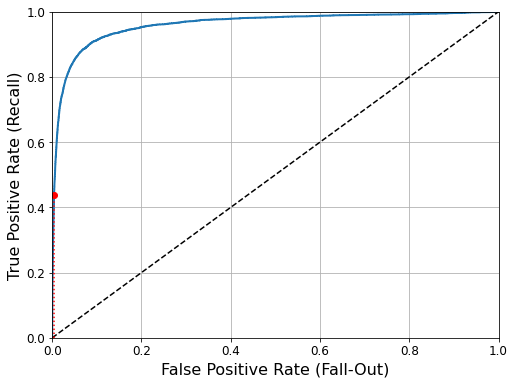

In [39]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

__trade-off__: the higher the recall (TPR), the more false positives (FPR) the classifier produces
- The dotted line represents the ROC curve of a purely random classifier
- a good classifier stays as far away from that line as possible (toward the top-left corner)
- the red circle highlights the chosen ratio (at 43.68% recall)

__Compare the classifier__:  measure the area under the curve (AUC)
- A perfect classifier will have a ROC AUC equal to 1
- a purely random classifier will have a ROC AUC equal to 0.5

In [40]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

- Tip: you should prefer the precision/recall PR curve ___whenever the positive class is rare___ or when you care more about the __false positives__ than the false negatives.

### Train a RandomForestClassifier
- Compare the ROC curve and ROC AUC score to those of the __SGDClassifier__
- the RandomForestClassifier class does not have a decision_function() method. Instead, it has a ___predict_proba()___ method.
- The ___predict_proba()___ method returns an ___array___ containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class
- e.g., 70% chance that the image represents a 5

In [41]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [42]:
# instead of scores you can give it class probabilities
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

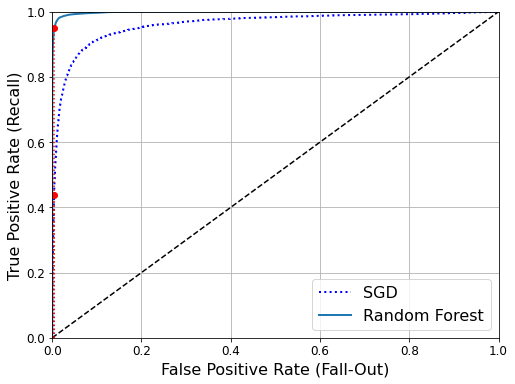

In [43]:
#Compare this ROC curve with the previous one (which is using SGDClassifier) 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [44]:
# ROC AUC score is also significantly better for Random Forest Classifier
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [45]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
# see the precision score and recall score
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [46]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## Train binary classifiers(Summary)
1. choose the appropriate metric for your task
2. evaluate your classifiers using cross-validation
3. select the precision/recall trade-off that fits your needs
4. use ROC curves and ROC AUC scores to compare various models

# Multiclass Classification

multinomial classifiers:
- Some algorithms (such as SGD classifiers, Random Forest classifiers, and naive Bayes classifiers) are capable of handling multiple classes natively
- Others (such as Logistic Regression or Support Vector Machine classifiers) are strictly binary classifiers
- various strategies that you can use to perform multiclass classification with __multiple binary classifiers__

Strategy 1: (create a system that can classify the digit images into 10 classes)
- rain 10 binary classifiers, one for each digit 
- get the __decision score__ from each classifier for that image and select the class whose classifier outputs the __highest score__.
- This is called the ___one-versus-the-rest___ (OvR) strategy (also called one-versus-all)

Strategy 2:
- Train a binary classifier for every pair of digits: <br\>
  one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s....
- This is called the __one-versus-one__ (OvO) strategy
- If there are N classes, you need to train ___N × (N – 1) / 2___ classifiers.
-  For the MNIST problem, this means training 45 binary classifiers! to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels
- main advantage of OvO : each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish

Some algorithms (such as Support Vector Machine classifiers) scale poorly with
the size of the training set 
- -->  __OvO is preferred__ --> faster to train many classifiers on small training sets
- For most binary classification algorithms, however, ___OvR is preferred___

__Try the Support Vector Machine classifier__

In [47]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

The scikit learn actually used the OvO strategy:
- __decision_function()__ method, you will see that it returns 10 scores per instance (instead of just 1).
- select the best score as prediction

In [48]:
some_digit_scores = svm_clf.decision_function([some_digit])
# display all the ten scores
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [49]:
# highest score belongs to which class
np.argmax(some_digit_scores)

5

In [50]:
# display the list of target classes 
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [51]:
svm_clf.classes_[5]

5

__use the OneVsOneClassifier or OneVsRestClassifier classes in Scikit learn__

In [52]:
from sklearn.multiclass import OneVsRestClassifier

# create an instance and pass a classifier to its constructor 
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [53]:
len(ovr_clf.estimators_)

10

In [54]:
# no need to run OvR or OvO because SGD classifiers directly classify instances to multiple classes
sgd_clf.fit(X_train[:1000], y_train[:1000])
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [55]:
# the decision function returns one value(score) per class
sgd_clf.decision_function([some_digit])

array([[-6049581.97985829, -6138036.45541781, -3886281.38604606,
         -604692.42366776, -6948311.32017537,   914498.2913215 ,
        -6855666.78647961, -3866146.33271573, -4016434.08430155,
        -3209136.89074954]])

In [ ]:
# Evaluate performance using corss validation
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
# Feature scalling, to imporve the accuracy of prediction
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

# Error Analysis

In real Machine learning project:
- explore data preparation options, try out multiple models (shortlisting the best ones and fine-tuning their
  hyperparameters using __GridSearchCV__), and automate as much as possible
- Here, we will assume that you have found a promising model and you want to find ways to ___improve it___.
- analyze the types of errors it makes.

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [ ]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

more convenient to look at an __image
representation__ of the confusion matrix, using Matplotlib's matshow() function

In [ ]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

plot_confusion_matrix (conf_mx)

In [ ]:
# plot the confusion matrix by gray image
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Focus on the plot on the error: 
-  divide each value in the confusion matrix by the number of images in the corresponding class 
- To compare error rates instead of absolute numbers of errors 

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
# Fill the diagonal with zeros to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
plot_confusion_matrix (norm_conf_mx)

Observation:
- Errors occurs for false 8. (prediction of 8 wrongly)
- 3 and 5 are misunderstand with each other often

Analyzing individual errors to understand the working principle of the classifier.
- Plot the example of 3 and 5

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- The two 5 × 5 blocks on the left show digits classified as 3s, and the two 5 × 5
  blocks on the right show images classified as 5s.
- Wrong predictions: bottom left and top-right
- Why the classifier did this mistake ? --> the SGDClassifer is __linear model__ --> assign a weight per class to each pixel and sum up the weighted pixel intensitis to get a score for each class --> 3 and 5 only differs a few pixels
-  main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc.
-  this classifier is quite sensitive to image shifting and rotation.

####  __Solution:__  preprocess the images to ensure that they are well centered and not too rotated

# Multilabel Classification

- output multiple classes for each instance
- output multiple binary tags

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

Explain: 
- KNeighborsClassifier supports multilabel classification
- Create two target labels here: larger number (lager than 7) and odd numbers
- Train it in a __multiple targets array__
- Make a prediction: the outputs has two labels now.

In [ ]:
knn_clf.predict([some_digit])

Evaluation on the multilabel classifier:
- F1 score across all labels (or any other binary classifier metric)
- Then simply compute the average score

In [ ]:
# This code will take hours 
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
#f1_score(y_multilabel, y_train_knn_pred, average="macro")

Assumption: 
- All the labels are equally important
- Give each label a weight equal to its ___support___ (i.e. the number of instances with that target label)
- set __average="weighted"__ in the code

# Multioutput Classification

multioutput–multiclass classification
- a generalization of multilabel classification where __each label can be multiclass__ (more than 2 possible values)

For illustration: predicting pixel intensity 
- build a system removes noise from images
- input a noisy image, output a clean digit image. represented as an array of pixel intensities
- Classifier's output is multilabel (one label per pixel), each label can have multiple value (0-255)
- It is a multioutput classification system

In [ ]:
# Create training sets and test sets by adding noise to the pixels using Numpy randint() method
# The target image will be the original image
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
# take a peek at images from test sets
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index]) # noisy image
plt.subplot(122); plot_digit(y_test_mod[some_index]) # target image
plt.show()

In [ ]:
# now train the classifier and make it clean the image
# The classifier herer is KNN
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)